# <span style="color:blue;">OpenPIV-Python-CPU Tutorial</span>

Please use the following link to run this notebook from Google Colab:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ali-sh-96/openpiv-python-cpu/blob/main/tutorials/openpiv_python_cpu_tutorial.ipynb)

## <span style="color:blue;">Introduction</span>

This tutorial demonstrates the use of each of openpiv-python-cpu for particle image velocimetry (PIV) analysis. The data used here are synthetic vortex images (http://www.pivchallenge.org/pub/#b) and separated flow over an airfoil (aquired in Turbulence Research Lab, University of Toronto). The synthetic images are 512 by 512 pixels squared while the separated flow images are 2052 by 4606 pixels squared and approximately 14.1 MB large. The output from the PIV analyses is displayed as vector plots.

See the References section to understand the mathematical foundations of iterative multigrid approach in PIV. In brief, for every iteration, the alogrithm estimates the velocity field by cross-correlation of square regions around measurement nodes, known as interrogation windows. The estimated velocity field is used to shift and deform the windows used in the next iteration, resulting in a more accurate estimation. In between iterations, the estimated velocity field can be processed by smoothing and validation routines. Smaller windows allow for more local estimates of the velocity at the risk of producing spurious vectors.

## <span style="color:blue;">Import Dependencies</span>

In [1]:
import os
import sys
from glob import glob
import time

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import numpy as np
import IPython.display as display

## <span style="color:blue;">Add OpenPIV to System Path</span>

In [3]:
# Install pyfftw.
!pip install pyfftw

# Clone the repository.
!git clone https://github.com/ali-sh-96/openpiv-python-cpu.git

openpiv_path = '/content/openpiv-python-cpu/'
sys.path.append(openpiv_path)
from openpiv.cpu_process import piv_cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 8.2 MB/s eta 0:00:00
Cloning into 'openpiv-python-cpu'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (109/109), done.
remote: Compressing objects: 100% (94/94), done.
remote: Total 109 (delta 54), reused 40 (delta 12), pack-reused 0
Receiving objects: 100% (109/109), 28.44 MiB | 26.72 MiB/s, done.
Resolving deltas: 100% (54/54), done.


## <span style="color:blue;">Important Notes for Usage</span>

PIV parameters can be modified for each pass. However, once set, these parameters remain constant throughout all iterations for the given window size. Certain PIV parameters are disregarded during the initial iteration, while others are ignored during the final iteration. To illustrate the usage of these parameters, two cases are provided below. It's important to note that the shape of images and the minimum window size are not considered as PIV settings, and users are required to provide this information when calling the processor.

In this implementation, the interrogation process relies on the search size rather than the window size. During extended search PIV, the search window is reduced by a shrink ratio. This approach is adopted to ensure that the search size always remains a power of two, which leads to improved performance. Note that extended search PIV is only applicable to the first iteration.

Adjusting the correlation width is possible by configuring the number of FFT points. Employing more points leads to improved accuracy and reduces the presence of outliers in each iteration. However, it is important to consider that using more points significantly increases computation time. As a practical recommendation, it is advised to set the number of FFT points to 2 for the final pass to strike a balance between accuracy and computation efficiency.

In the existing implementation, the validation method is selected by defining a validation tolerance for each specific method. You have the option to employ a combination of these methods by assigning different validation tolerances to each. When a tolerance is set to `None` for a particular method, it will be bypassed during the validation process. The default method is median validation with a tolerance of 2 for the entire process.

When applying a mask, note that all values inside the mask are set to `np.nan`. while using `np.nan` is compatible with Python and many scientific libraries, it may cause problems if the results are exported for use in other software that does not handle `np.nan` in the same way. To avoid such problems when exporting data for use in other software, you may replace `np.nan` with an appropriate value, such as 0.

By default, the algorithms in this implementation use single precision floating point. However, if you need higher precision and want to utilize double precision, you can easily achieve that by setting the float type to `"float64"` in the PIV settings.

## <span style="color:blue;">Synthetic Vortex Images</span>

This section demonstrates the usage of synthetic images containing a strong vortex with variations in seeding concentration and particle image size. The analysis focuses on four distinct cases to illustrate the impact of validation and replacement methods on the final results. Note how the results change at the center of vortex where signal-to-noise levels are low.

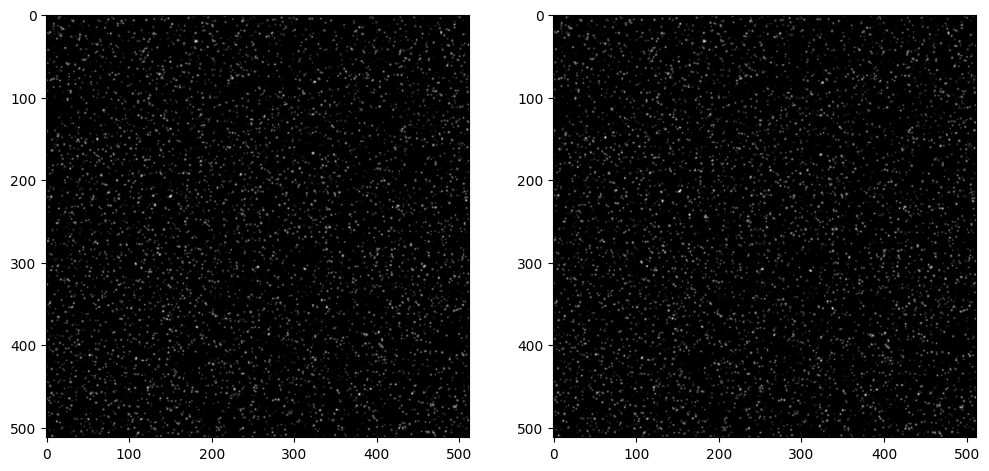

In [4]:
# Load the test images.
test_dir = "./openpiv-python-cpu/tutorials/test1/"
frame_a = cv2.imread(test_dir + "B005_1" + ".tif", cv2.IMREAD_ANYDEPTH)
frame_b = cv2.imread(test_dir + "B005_2" + ".tif", cv2.IMREAD_ANYDEPTH)

# Show the test images.
fig, ax = plt.subplots(1, 2, figsize=(12,10))
ax[0].imshow(frame_a, cmap=plt.cm.gray)
ax[1].imshow(frame_b, cmap=plt.cm.gray)
plt.show()

In [5]:
# Set PIV settings.
settings = {}

# Passes and iterations.
settings["search_size_iters"] = (1, 2, 2,)

# Geometry settings.
settings["overlap_ratio"] = (0.5, 0.5, 0.5,)
settings["shrink_ratio"] = 1

# Correlation settings.
settings["deforming_order"] = 2
settings["normalize"] = True
settings["subpixel_method"] = "gaussian"
settings["n_fft"] = 2
settings["deforming_par"] = 0.5
settings["batch_size"] = 1

# Validation Settings.
settings["s2n_method"] = "peak2peak"
settings["s2n_size"] = 2
settings["validation_size"] = 1
settings["s2n_tol"] = None
settings["median_tol"] = 2
settings["mad_tol"] = None
settings["mean_tol"] = None
settings["rms_tol"] = None

# Replacement Settings.
settings["num_replacing_iters"] = 2
settings["replacing_method"] = "spring"
settings["replacing_size"] = 1
settings["revalidate"] = True

# Smoothing Settings.
settings["smooth"] = True
settings["smoothing_par"] = None

# Scaling Settings.
settings["dt"] = 1
settings["scaling_par"] = 1

# Mask settings.
settings["mask"] = None

# Float data type setting.
settings["dtype_f"] = "float32"

In [6]:
# Let's perform 4 analysis, using different validation and replacement settings.
u = []
v = []
loc = []

# Set mandatory settings.
frame_shape = frame_a.shape
min_search_size = 16

# Case 1: s2n validation, local mean replacing.
settings["s2n_tol"] = 2
settings["median_tol"] = None
settings["num_replacing_iters"] = 5
settings["replacing_method"] = "mean"
settings["revalidate"] = True
process = piv_cpu(frame_shape, min_search_size, **settings)

# Case 1 analysis.
up, vp = process(frame_a, frame_b)
u.append(up)
v.append(vp)
loc.append(process.val_locations)

# Case 2: median validation, local mean replacing.
settings["s2n_tol"] = None
settings["median_tol"] = 2
settings["num_replacing_iters"] = 5
settings["replacing_method"] = "mean"
settings["revalidate"] = True
process = piv_cpu(frame_shape, min_search_size, **settings)

# Case 2 analysis.
up, vp = process(frame_a, frame_b)
u.append(up)
v.append(vp)
loc.append(process.val_locations)

# Case 3: s2n validation, spring replacing.
settings["s2n_tol"] = 2
settings["median_tol"] = None
settings["num_replacing_iters"] = 2
settings["replacing_method"] = "spring"
settings["revalidate"] = True
process = piv_cpu(frame_shape, min_search_size, **settings)

# Case 3 analysis.
up, vp = process(frame_a, frame_b)
u.append(up)
v.append(vp)
loc.append(process.val_locations)

# Case 4: median validation, spring replacing.
settings["s2n_tol"] = None
settings["median_tol"] = 2
settings["num_replacing_iters"] = 2
settings["replacing_method"] = "spring"
settings["revalidate"] = True
process = piv_cpu(frame_shape, min_search_size, **settings)

# Case 4 analysis.
up, vp = process(frame_a, frame_b)
u.append(up)
v.append(vp)
loc.append(process.val_locations)

# Get coordinates of images.
x, y = process.coords

# Get field mask (All False if mask not passed).
field_mask = process.field_mask

# invert y axis for all.
y = y[::-1]
v = [-vk for vk in v]

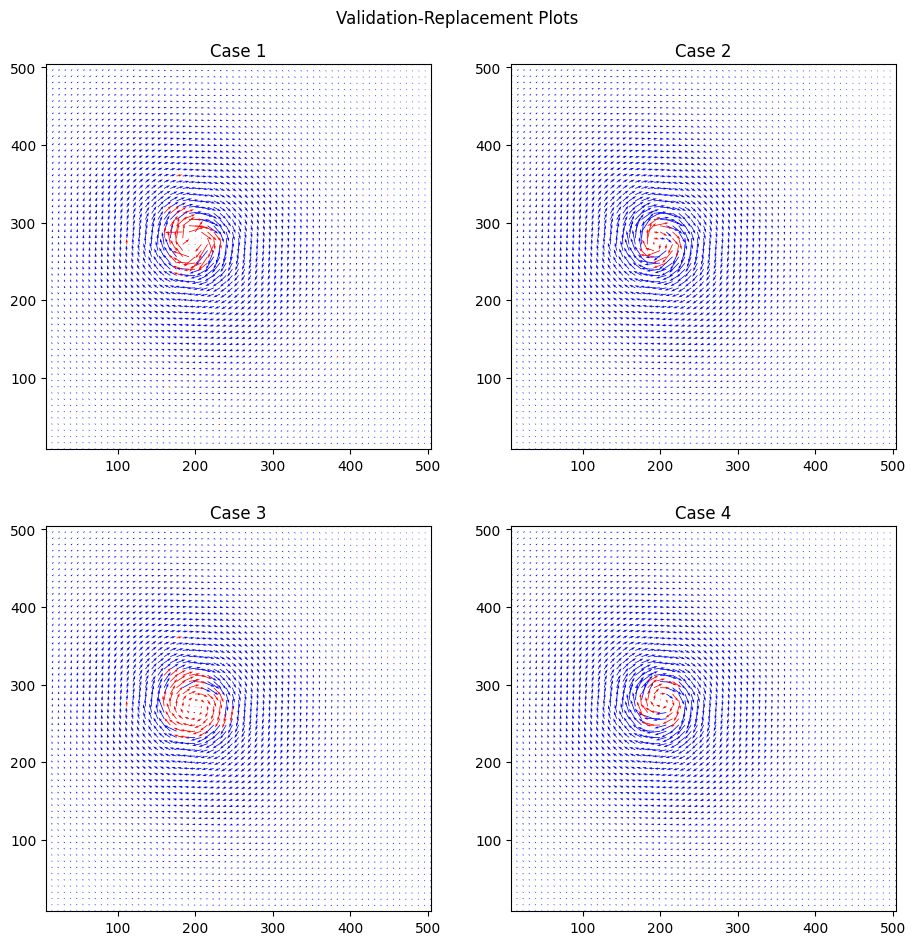

In [7]:
# Create a figure with subplots.
fig, axs = plt.subplots(2, 2, figsize=(11, 11))

vector_width = 0.002
vector_scale = 250

# Plot the quiver plots.
for i, ax in enumerate(axs.flatten()):
    ax.quiver(x[~loc[i]], y[~loc[i]], u[i][~loc[i]], v[i][~loc[i]], color="blue", width=vector_width, scale=vector_scale)
    ax.quiver(x[loc[i]], y[loc[i]], u[i][loc[i]], v[i][loc[i]], color="red", width=vector_width, scale=vector_scale)

    # Plot settings.
    ax.set_aspect(1)
    ax.set_xlim(np.min(x), np.max(x))
    ax.set_ylim(np.min(y), np.max(y))

# Set titles and labels.
axs[0, 0].set_title('Case 1')
axs[0, 1].set_title('Case 2')
axs[1, 0].set_title('Case 3')
axs[1, 1].set_title('Case 4')

# Adjust spacing between subplots.
fig.subplots_adjust(wspace=0.2, hspace=0.2)

fig.suptitle('Validation-Replacement Plots', y=0.93)
plt.show()

## <span style="color:blue;">Separated Flow Images</span>

This section demonstrates the application of actual Particle Image Velocimetry (PIV) images for studying separated flow over an airfoil. An airfoil mask, represented by an array of nonzero values, is used to mask specific data points. Conversely, the mask assigns zero values to the non-masked regions. Pay attention to the parameters that differ for the final pass in order to get a dense vector field with high accuracy.

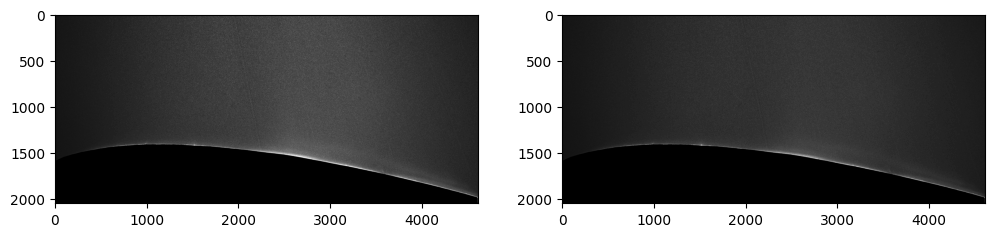

In [8]:
# Load the airfoil images.
data_dir = "./openpiv-python-cpu/tutorials/test2/"
tif_files = glob(os.path.join(data_dir + '*.tif'))

# Show airfoil images.
frame_a = cv2.imread(tif_files[0], cv2.IMREAD_ANYDEPTH)
frame_b = cv2.imread(tif_files[1], cv2.IMREAD_ANYDEPTH)

fig, ax = plt.subplots(1, 2, figsize=(12,10))
ax[0].imshow(frame_a, cmap=plt.cm.gray)
ax[1].imshow(frame_b, cmap=plt.cm.gray)
plt.show()

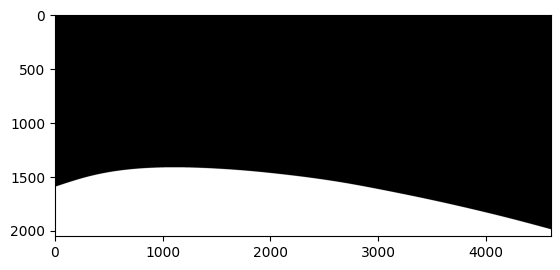

In [9]:
# Load and show airfoil mask.
mask = cv2.imread(data_dir + "airfoil_mask.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(mask, cmap=plt.cm.gray)
plt.show()

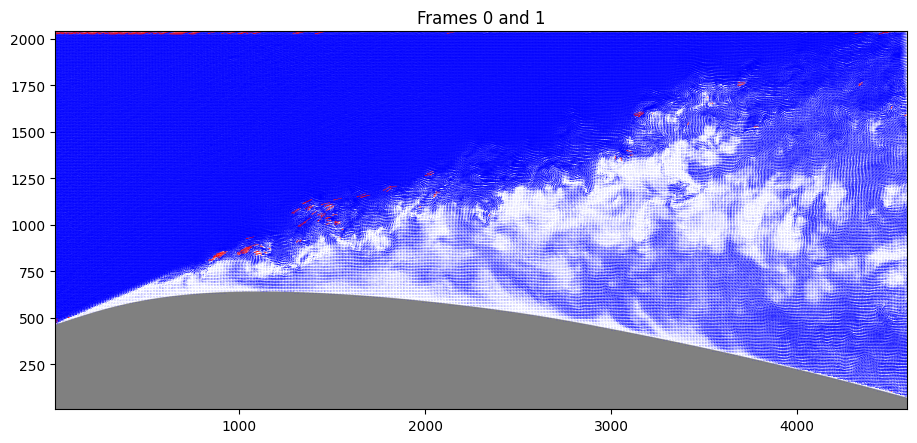

Computation time for 1 image pairs was 24.905 s.
Average time per image pair was 24.905 s.


In [11]:
# Number of images to process.
frame_start = 0
n_frames = 2
k_frames = [tuple(range(start, start + 2)) for start in range(frame_start, frame_start + n_frames, 2)]

# Initialize variables for reporting performance.
process_time = 0
n_frame_pairs = 0

frame_shape = frame_a.shape
process = piv_cpu(frame_shape,
                  min_search_size=16,
                  search_size_iters=(1, 2, 2),
                  overlap_ratio=(0.5, 0.5, 0.5),
                  shrink_ratio=1,
                  deforming_order=2,
                  normalize=True,
                  subpixel_method="gaussian",
                  n_fft=(1, 2, 2,),
                  deforming_par=0.5,
                  batch_size=1,
                  s2n_method="peak2peak",
                  s2n_size=2,
                  validation_size=1,
                  s2n_tol=None,
                  median_tol=2,
                  mad_tol=None,
                  mean_tol=None,
                  rms_tol=None,
                  num_replacing_iters=1,
                  replacing_method="spring",
                  replacing_size=1,
                  revalidate=False,
                  smooth=True,
                  smoothing_par=None,
                  mask=mask,
                  dtype_f="float32")

# Get coordinates.
x, y = process.coords
y = y[::-1]

# Plot the results.
fig, ax = plt.subplots(figsize=(11, 11))
ax.set_aspect(1)
vector_width = 0.0005
vector_scale = 1000

# Adjust the axis limits to the minimum and maximum range.
ax.set_xlim(np.min(x), np.max(x))
ax.set_ylim(np.min(y), np.max(y))

for k in k_frames:
    start_time = time.time()
    i, j = k

    frame_a = cv2.imread(tif_files[i], cv2.IMREAD_ANYDEPTH)
    frame_b = cv2.imread(tif_files[j], cv2.IMREAD_ANYDEPTH)

    u, v = process(frame_a, frame_b)
    v = -v
    loc = process.val_locations
    _loc = ~loc

    process_time += time.time() - start_time

    # Update the quiver plot.
    ax.quiver(x[_loc], y[_loc], u[_loc], v[_loc], color="b", width=vector_width, scale=vector_scale)
    ax.quiver(x[loc], y[loc], u[loc], v[loc], color="r", width=vector_width, scale=vector_scale)
    ax.set_title(f"Frames {i} and {j}")

    # Show the true areas of the mask in gray color.
    ax.imshow(~mask, cmap='gray', alpha=0.5, extent=[np.min(x), np.max(x), np.min(y), np.max(y)])

    # Display the updated plot.
    display.clear_output(wait=True)
    if n_frame_pairs != 0:
        display.display(fig)
    plt.pause(0.01)
    n_frame_pairs += 1

print('Computation time for {} image pairs was {:.3f} s.'.format(n_frame_pairs, process_time))
print('Average time per image pair was {:.3f} s.'.format(process_time / n_frame_pairs))

## <span style="color:blue;">Export Results to Matlab</span>

In [ ]:
from scipy.io import savemat

In [ ]:
# Select path for saving .mat file.
dir_files = ""

# Specify file name.
filename = ""
file = os.path.join(dir_files + filename + '.mat')

# Get field mask (All False if mask not passed).
field_mask = process.field_mask

# Set masked values to zero.
u[field_mask] = v[field_mask] = 0

# Save .mat file.
mdict = {"x": x, "y": y, "u": u, "v": v}
savemat(file, mdict)

## <span style="color:blue;">References</span>

> Raffel, M., Willert, C. E., & Kompenhans, J. (1998). Particle image velocimetry: a practical guide (Vol. 2, p. 218). Berlin: Springer.

> Scarano F, Riethmuller ML (1999) Iterative multigrid approach in PIV image processing with discrete window offset. Exp Fluids 26:513–523
    
> Meunier, P., & Leweke, T. (2003). Analysis and treatment of errors due to high velocity gradients in particle image velocimetry. Experiments in fluids, 35(5), 408-421.